In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Before we get started, let's take a quick look at datasets.

**The objective of the dataset**

> This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**The Pima Indian Diabetes data set consists of:**

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

--------------------------------------------------------------------------------------------------------------------------
# Load Libraries

In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(action='ignore')

# Defining Utility functions

In [3]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

# Reading and Checking data

In [4]:
diabetes_df = pd.read_csv("diabetes.csv")
diabetes_df.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
Pregnancies,6.000000,1.000000,8.000000,1.000000,0.000000
Glucose,148.000000,85.000000,183.000000,89.000000,137.000000
BloodPressure,72.000000,66.000000,64.000000,66.000000,40.000000
SkinThickness,35.000000,29.000000,0.000000,23.000000,35.000000
Insulin,0.000000,0.000000,0.000000,94.000000,168.000000
BMI,33.600000,26.600000,23.300000,28.100000,43.100000
DiabetesPedigreeFunction,0.627000,0.351000,0.672000,0.167000,2.288000
Age,50.000000,31.000000,32.000000,21.000000,33.000000
Outcome,1.000000,0.000000,1.000000,0.000000,1.000000


DiabetesPedigreeFunction has a long name. Change to DPF.

In [5]:
diabetes_df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

--------------------------------------------
# EDA

## Checking Missing Values and Data type
Let's check if there are missing values.

<AxesSubplot:>

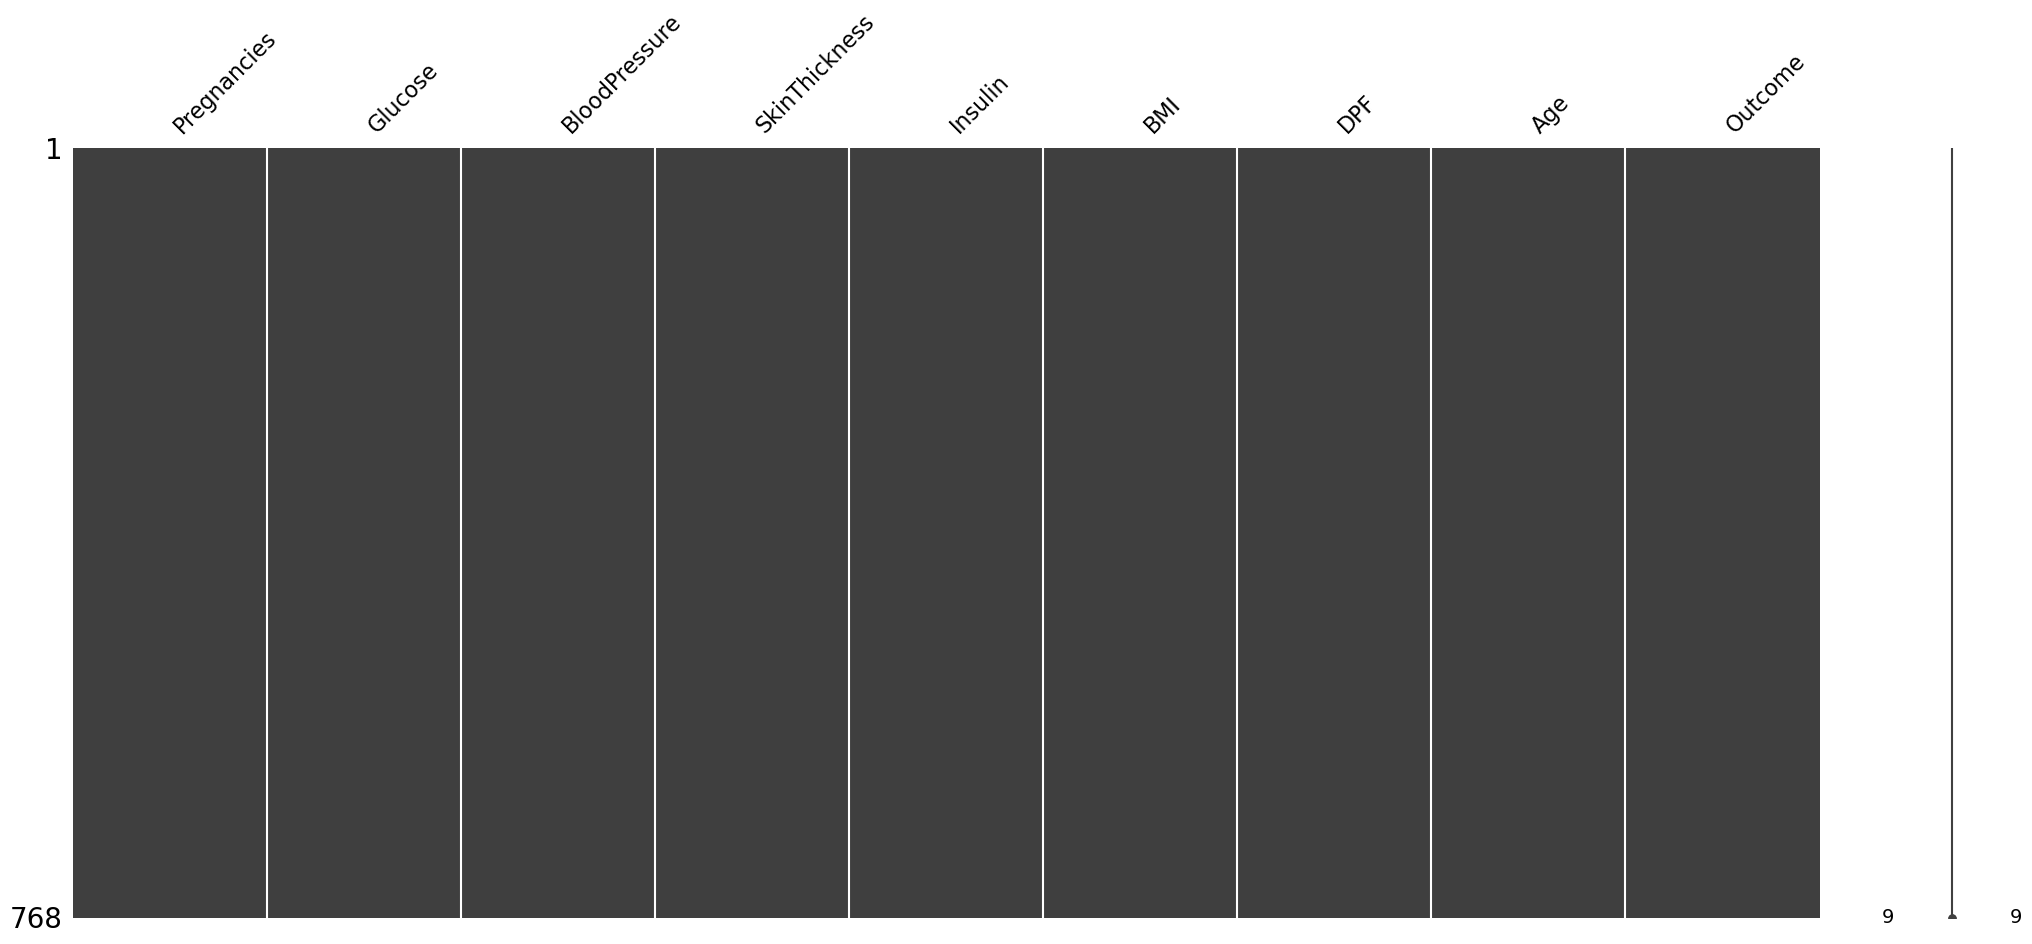

In [6]:
import missingno as msno
msno.matrix(diabetes_df)

**Good!. There is no missing value and all features type are number. Therefore, there is no need to preprocess for missing values.**

## Checking Target Imbalance

In [7]:
colors = ['gold', 'mediumturquoise']
labels = ['0','1']
values = diabetes_df['Outcome'].value_counts()/diabetes_df['Outcome'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Outcome")
fig.show()

OK! The target is well balanced.

## Checking Statistics

In [8]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')
diabetes_df.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Among the features, there are many features whose min() value is 0. Let's check out more of these features.**

--------------------------------------------------
# Checking and Removing Outliers

In [9]:
feature_names = [cname for cname in diabetes_df.loc[:,:'Age'].columns]

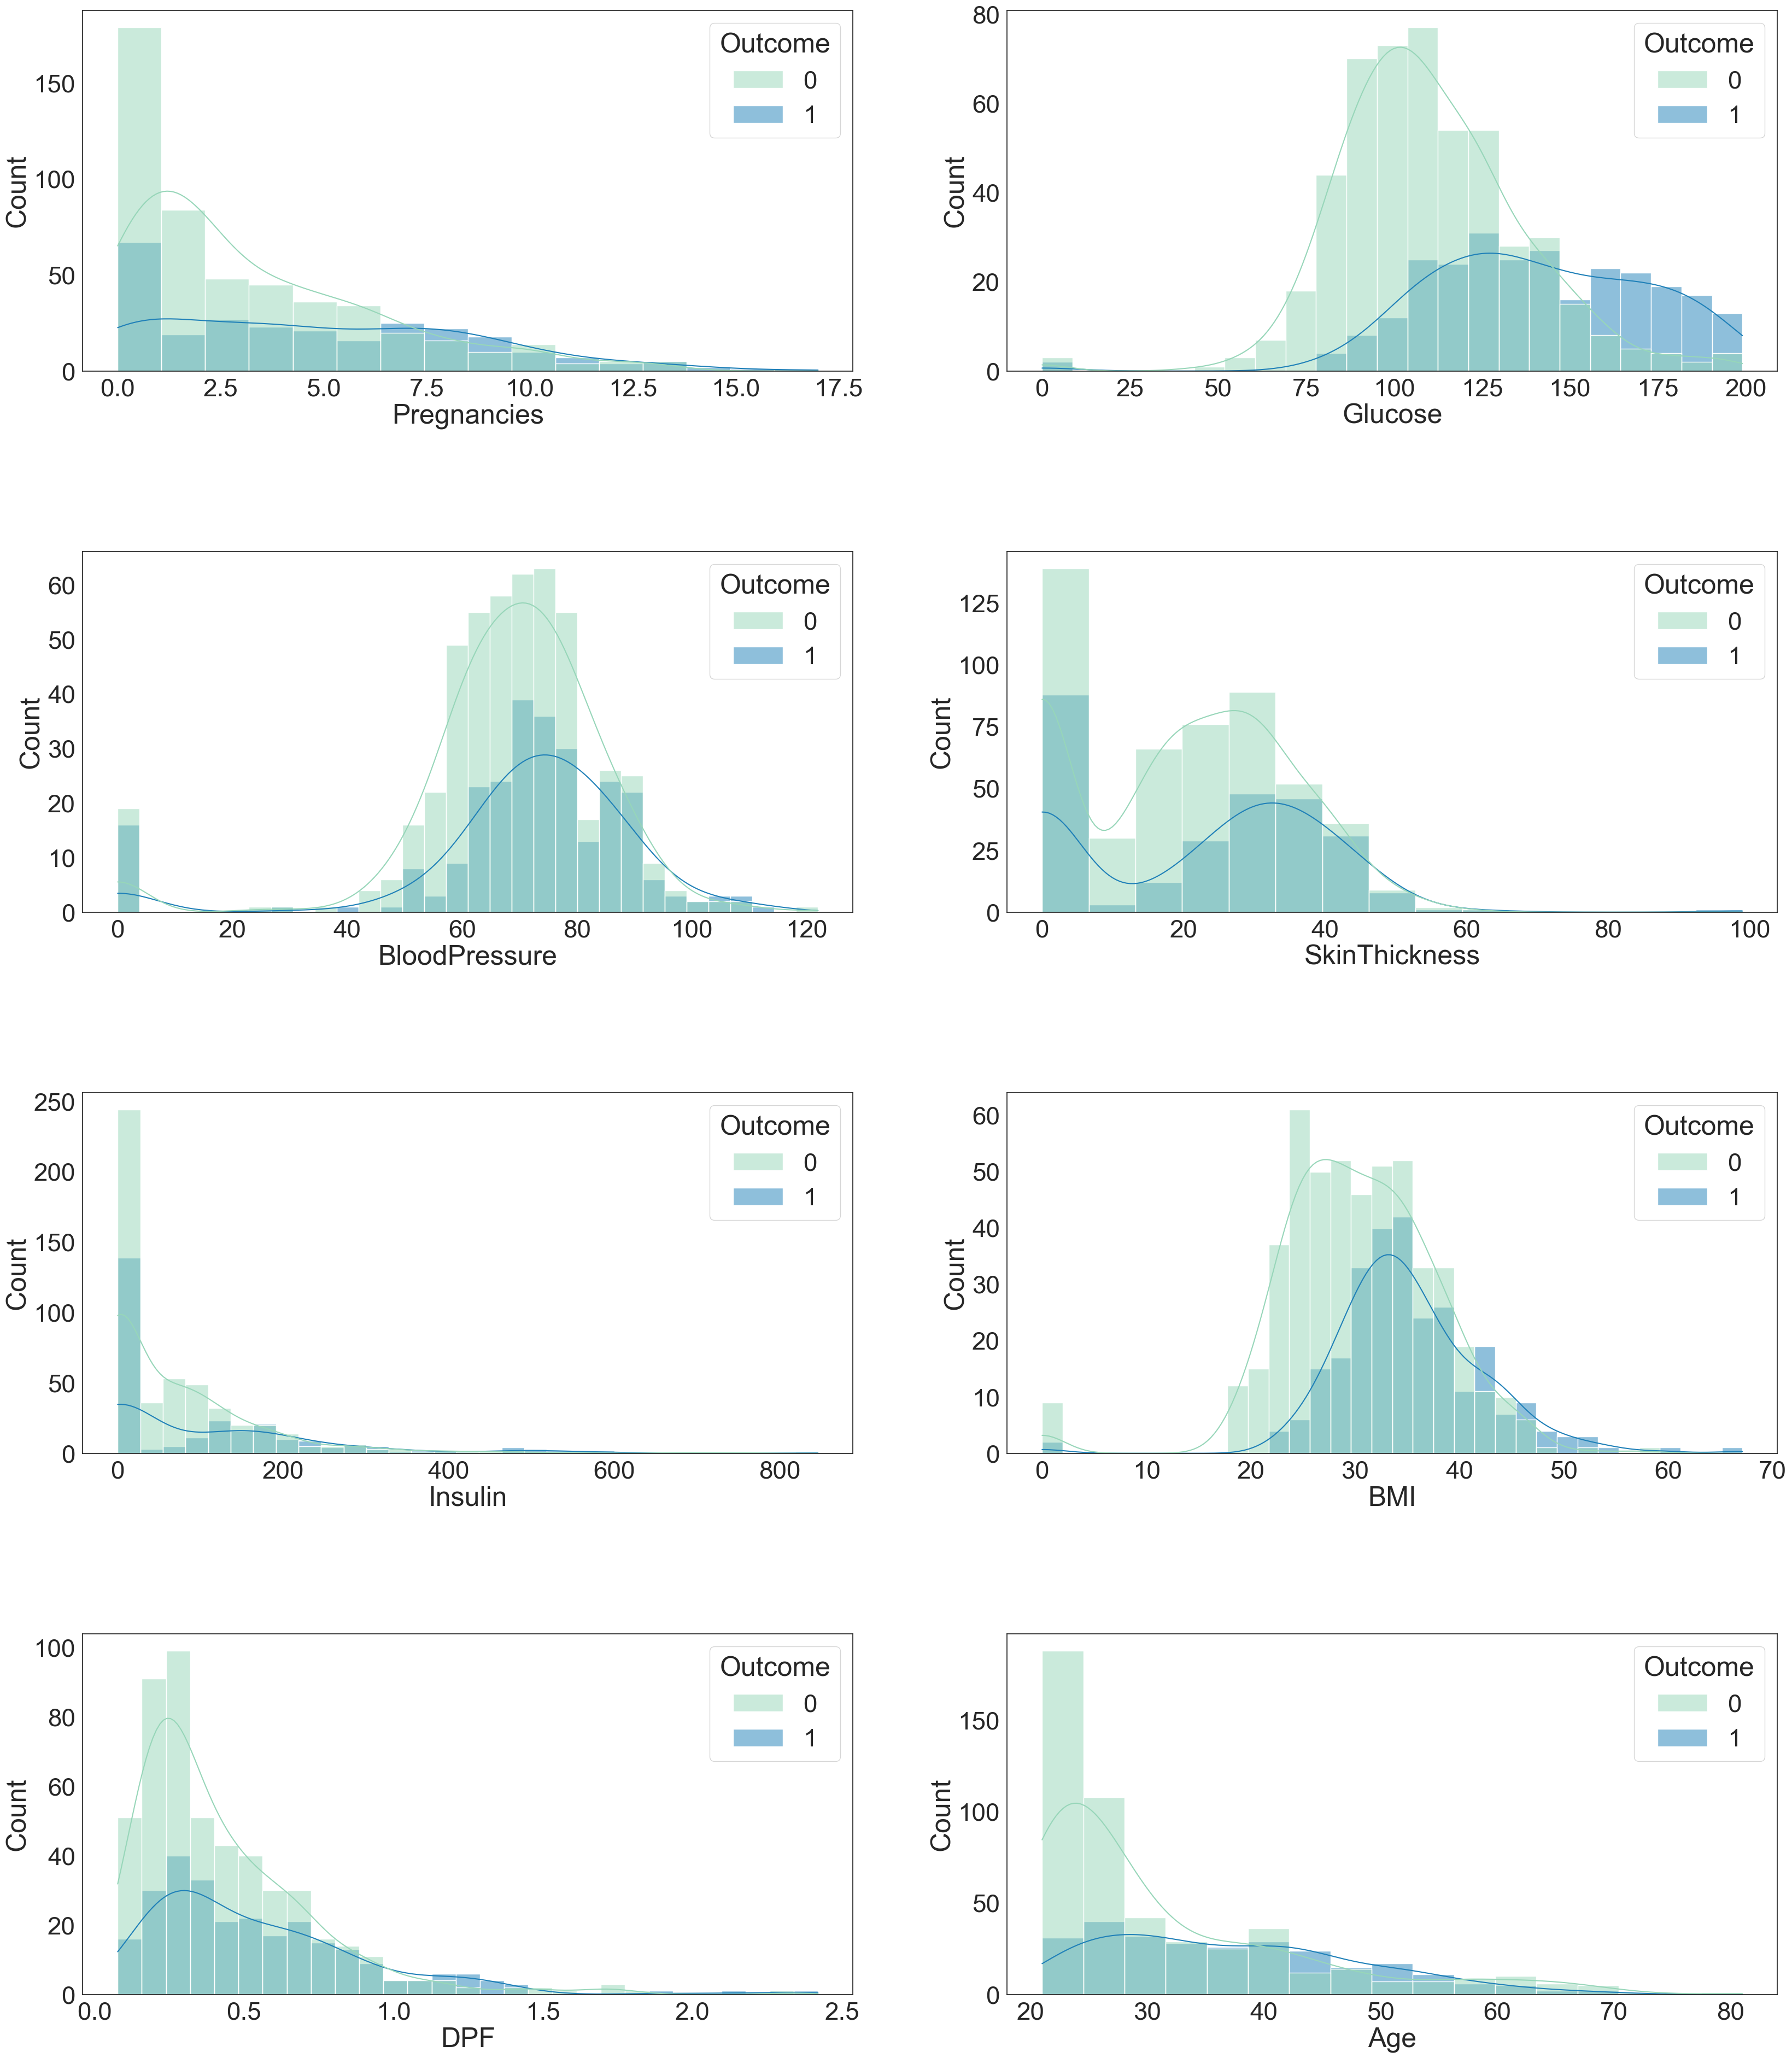

In [10]:
rcParams['fig.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Looking at the pictures above, it would be good to change the zero value of each feature to another value.
First, let's calculate the proportion of zero values in each feature.

In [11]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


As shown above, the ratio of the value of zero in the SkinThickness and Insulin features seems to be high. Let's change the corresponding values to the mean value of each feature. 

> However, a zero value may be meaningful to the corresponding feature. If you have an expert with expertise in diabetes, you will be able to confirm that your decision is correct.
However, since there is no such domain knowledge or friends, we will first replace the corresponding value with the mean value.

In [12]:
diabetes_mean = diabetes_df[zero_features].mean()
diabetes_df[zero_features]=diabetes_df[zero_features].replace(0, diabetes_mean)

If we remove the zero value of each feature, we have a distribution similar to the normal distribution. Therefore, perform linear scaling and standard scaling.

In [13]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

-------------------------------------------
# Scaling

Although the zero values of each feature are converted to mean values, some features have a one-sided shape. Therefore, we decided to perform nonlinear scaling, and decided to use the QuantileTransformer that changes the distribution closest to the normal distribution by referring to the notebook referenced below.

> The quantile function ranks or smooths out the relationship between observations and can be mapped onto other distributions, such as the uniform or normal distribution.

If you want to know more about Scaling, please refer to the notebook below.

[Notebook](https://www.kaggle.com/ohseokkim/preprocessing-linear-nonlinear-scaling)

In [14]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_scaled = scaler.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

X_train.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,4.315407,121.709154,72.144653,26.341978,118.600098,32.315027,0.468618,32.921875
std,2.916151,30.080570,12.113756,9.158041,94.570101,6.878494,0.339325,11.507539
min,1.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,2.000000,100.000000,64.000000,20.536458,79.799479,27.275000,0.240000,24.000000
50%,3.845052,118.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000
75%,6.000000,138.250000,80.000000,32.000000,127.500000,36.325000,0.612250,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


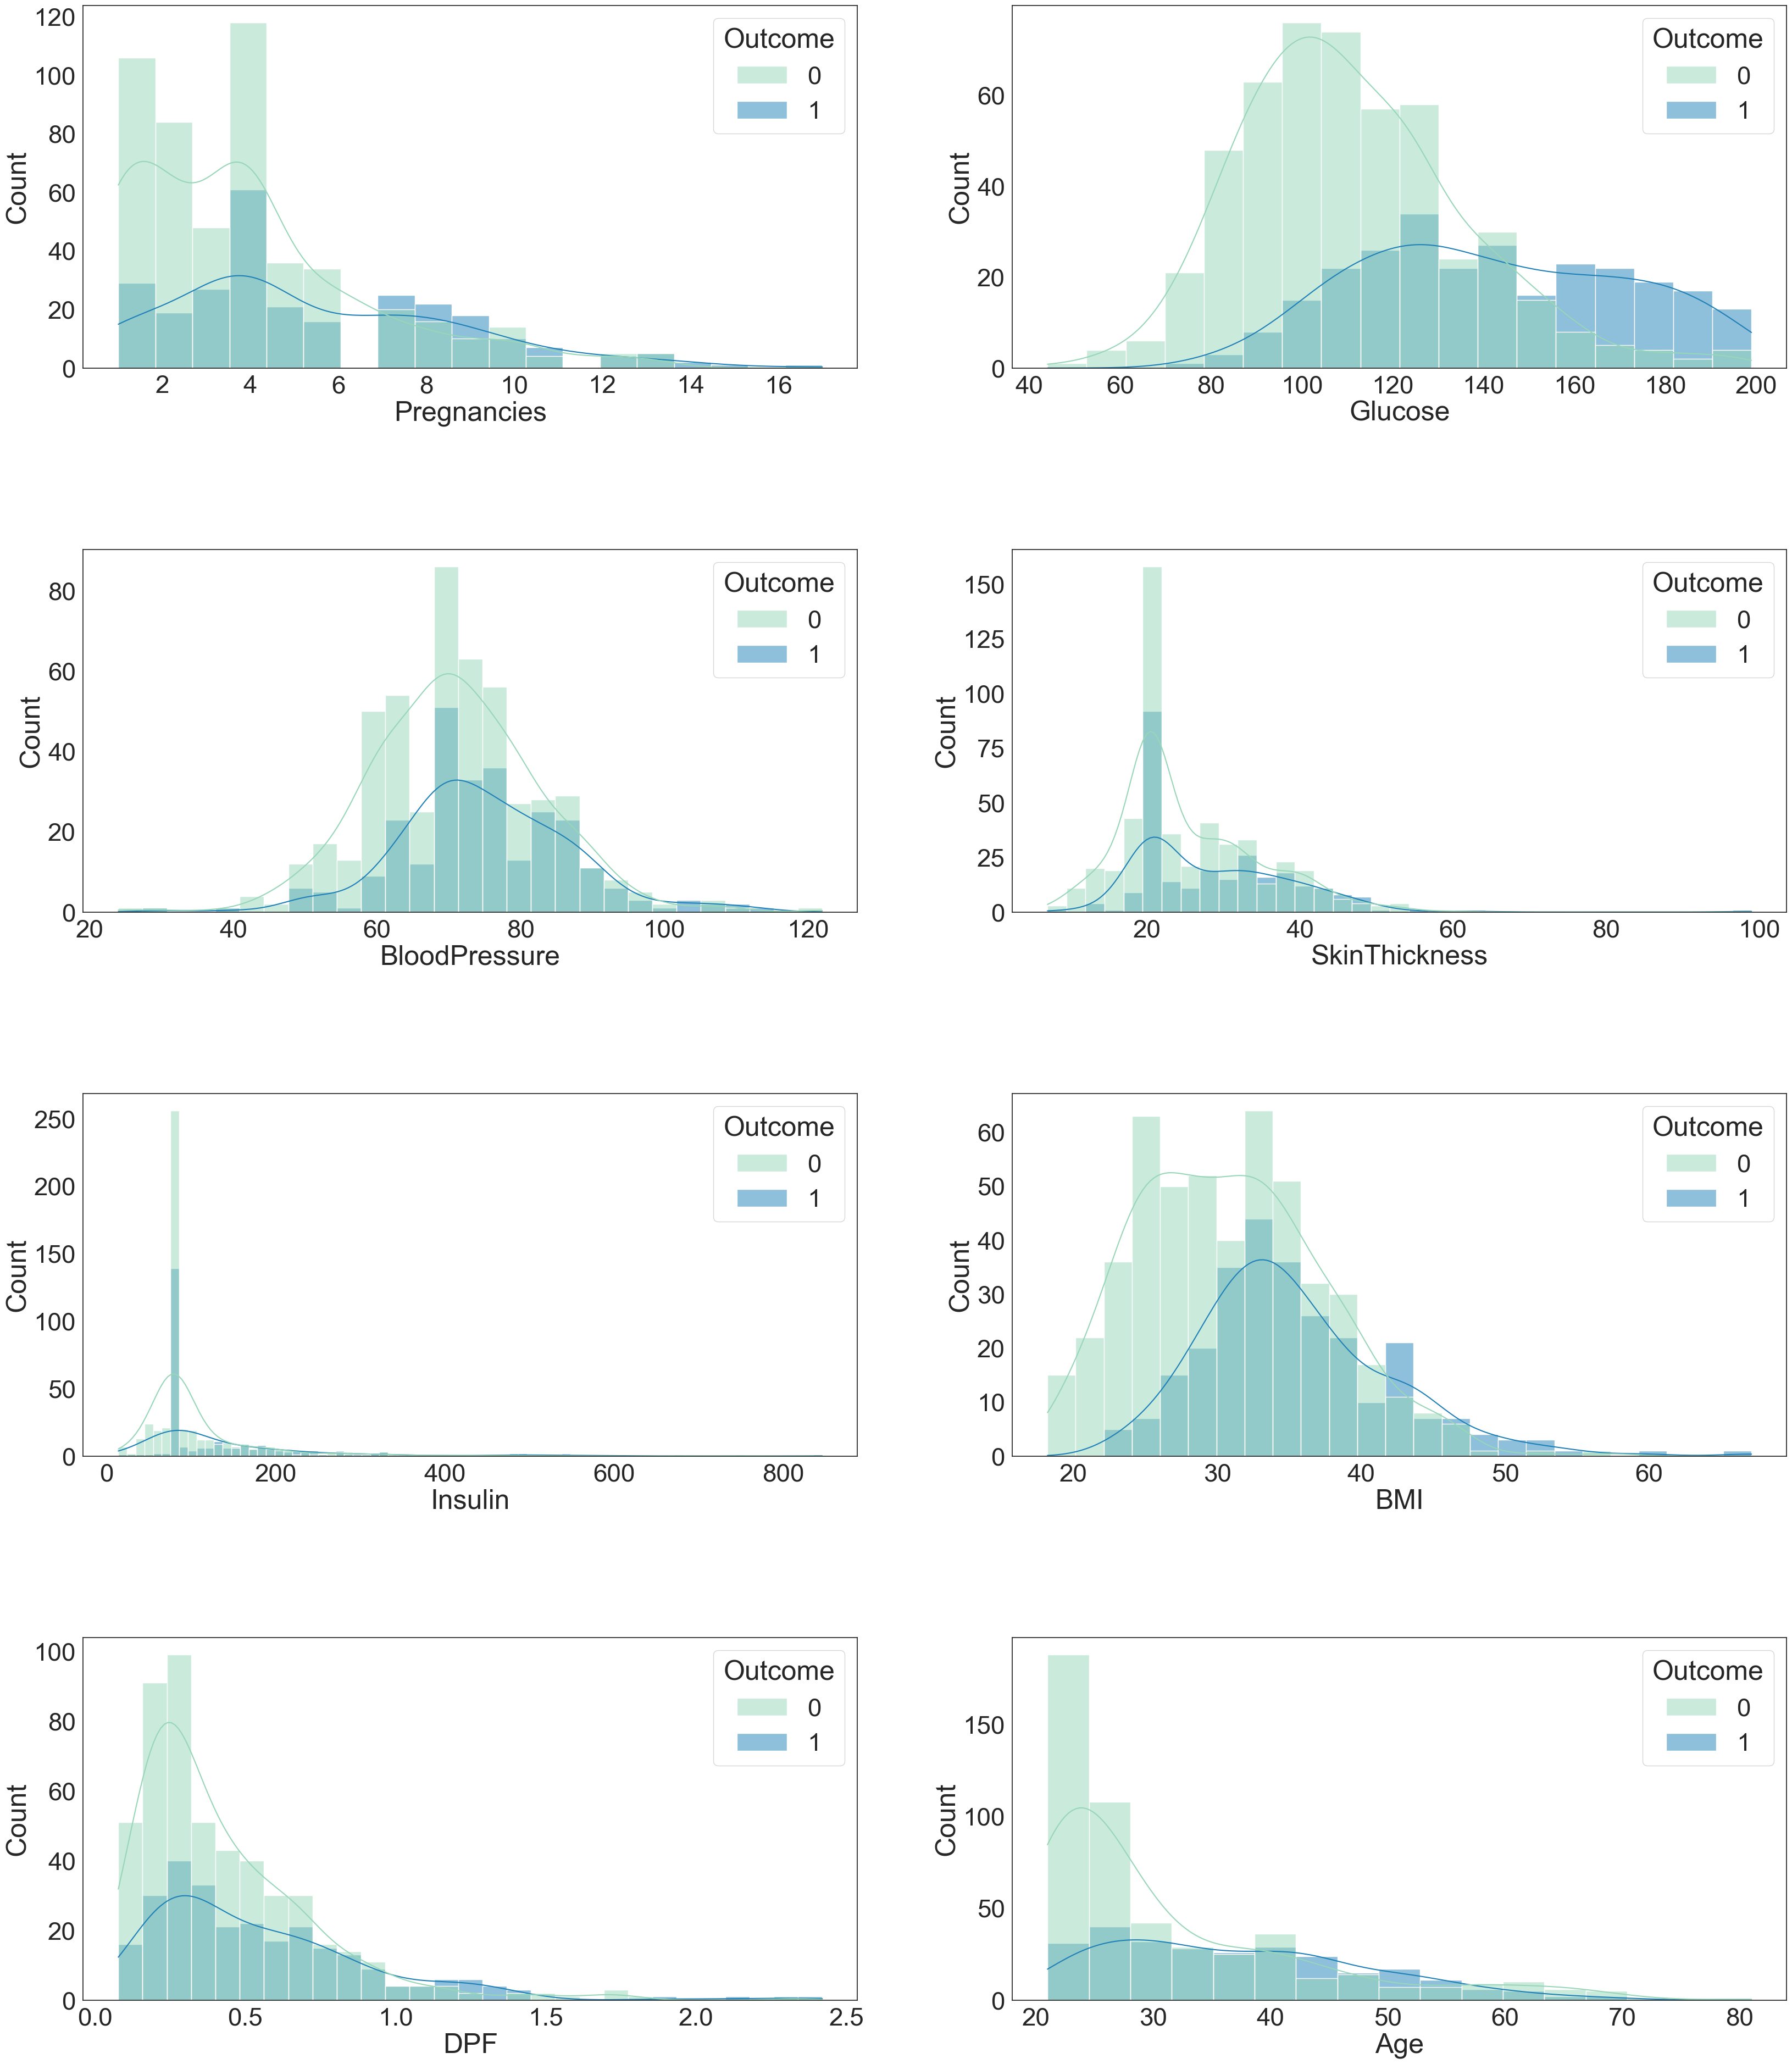

In [17]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Looking at the picture above, you can see that the zero value is removed and scaling is done. However, the shape of the distribution of Pregnancies does not look good.

# Checking correlation between features

Let's check the correlations between each variable.

Text(0.5, 1.0, 'Correlation Plot')

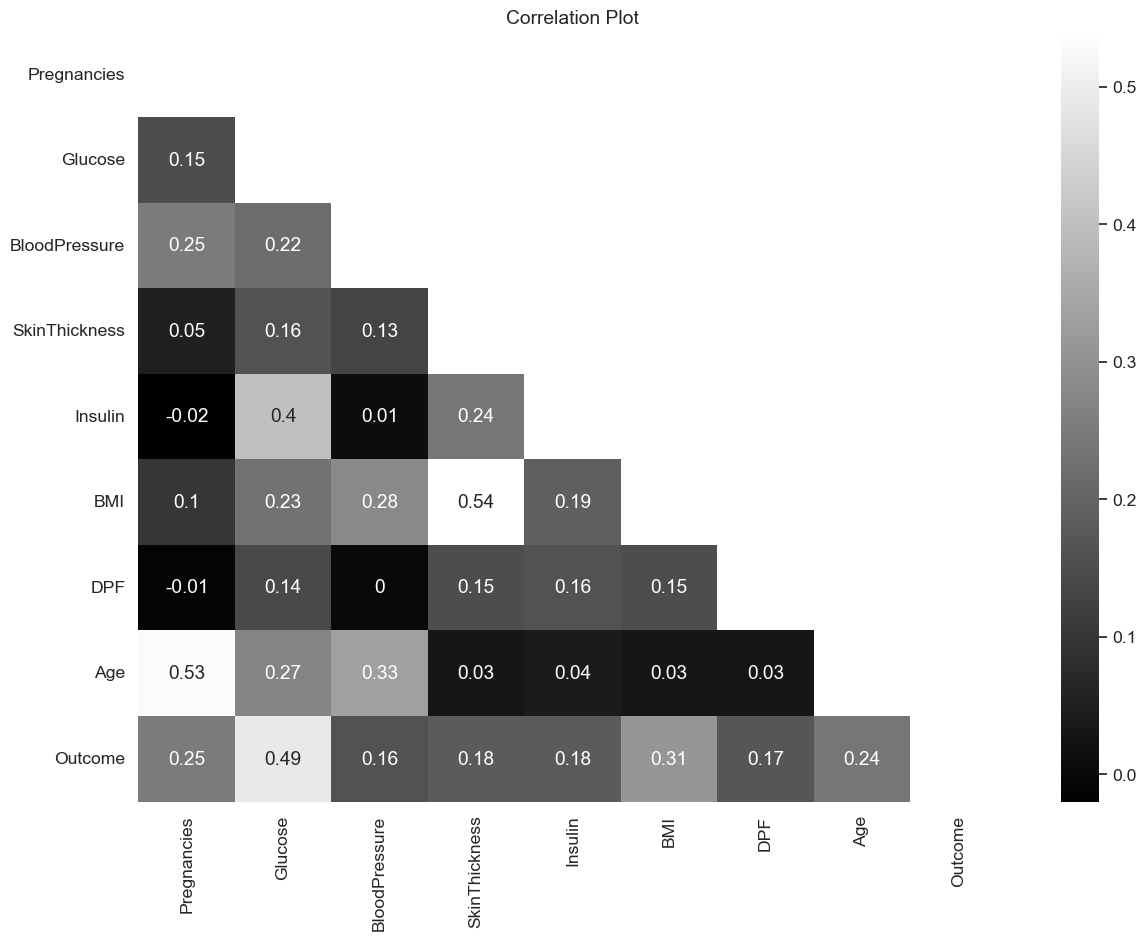

In [18]:
corr=diabetes_df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

<Figure size 1000x800 with 0 Axes>

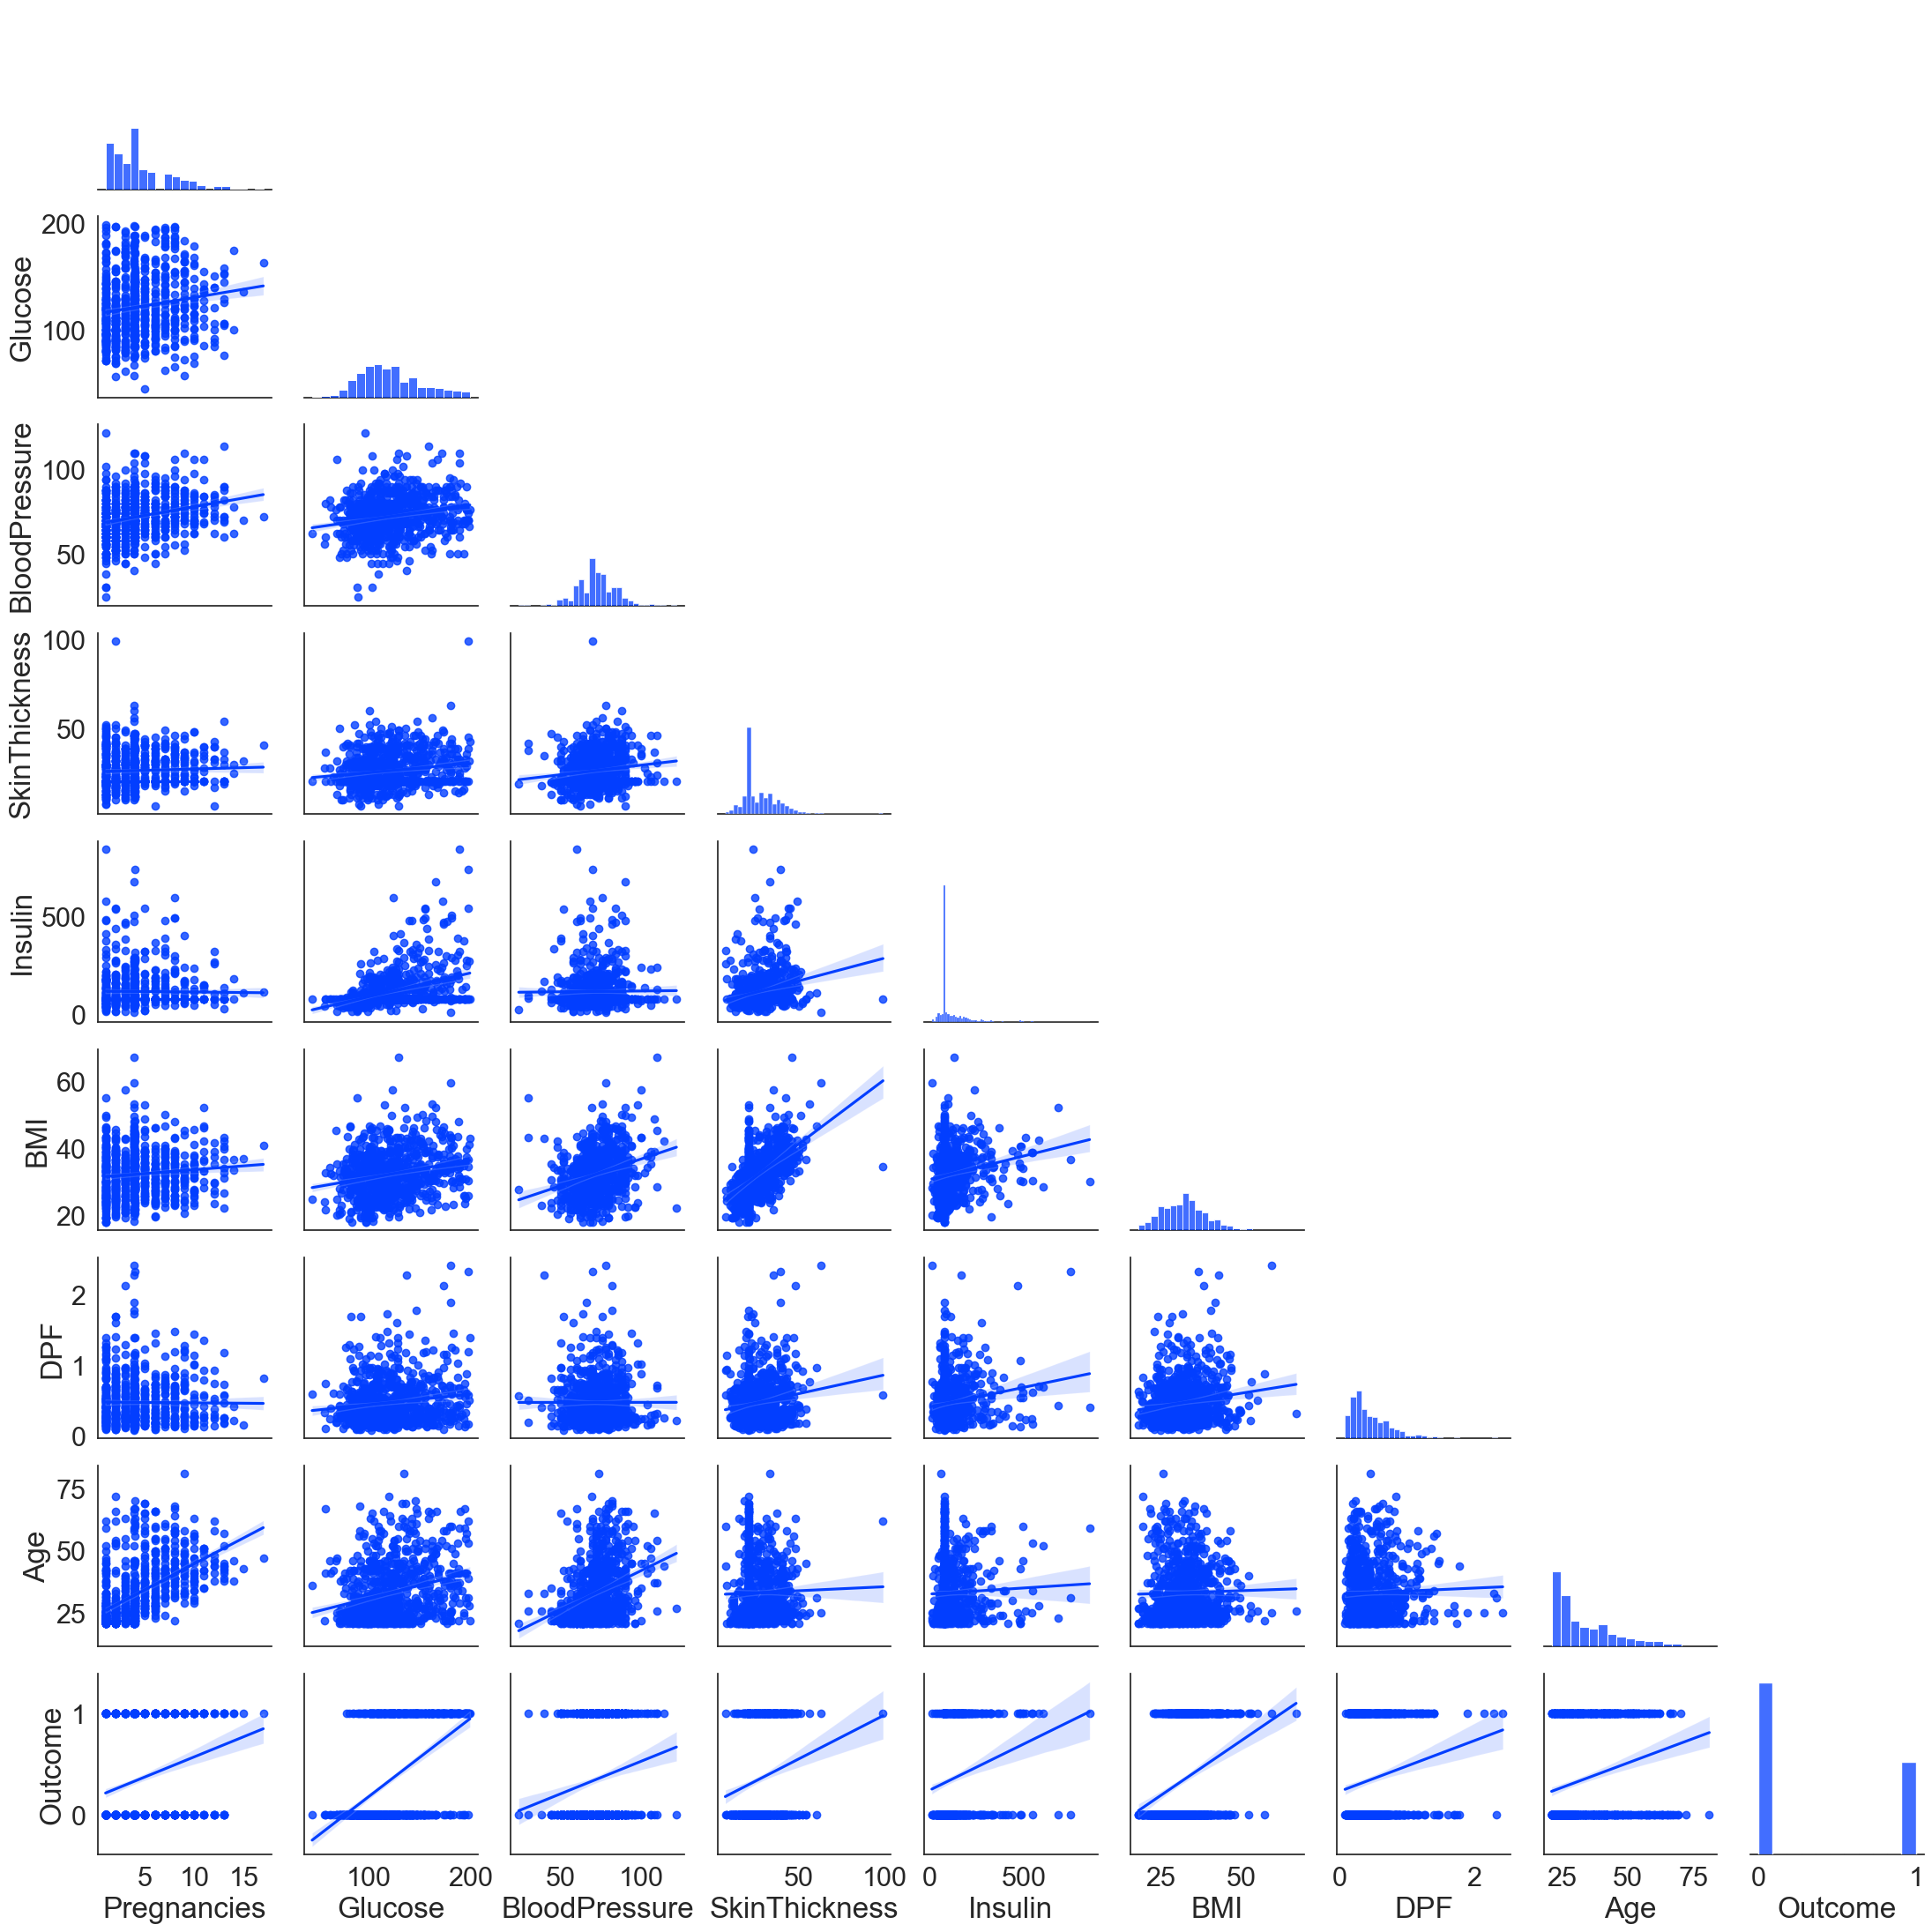

In [19]:
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(diabetes_df,kind = 'reg',corner = True,palette ='YlGnBu' )

<span style="color:Blue"> **Observation:**
* The correlation between Outcome and Glucose is high. Glucoe seems to be the most important feature in model training.
* BMI, Pregnancys, and Age are also expected to be used as important features in model training.
* High correlation coefficient with SkinThickness and BMI. There may be a multicollinearity problem, but if there is a performance problem after checking the result, check it again.

-----------------------------------------------
# Checking features before modeling

Looking at the figure above, the correlation coefficient between Outcome and Glucose is the highest at 0.49. Let's examine this in more depth.

In [20]:
fig = px.histogram(diabetes_df, x="Glucose", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Glucose Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [21]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="BMI", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "BMI Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [22]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="Age", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Age Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

From the above figures, you can see what distribution each feature has for each output. In the case of glucose with high correlation, it can be seen that the distribution of outcomes 1 and 0 has a more distant shape than other features. In this case, it is expected to have a better effect on classification.

----------------------------------------------------------------------------
# Visualizing Training Dataset after Dimension Reduction

In [23]:
X_train = diabetes_df.drop('Outcome',axis=1)
y_train = diabetes_df['Outcome']

## 2D plot

In [ ]:
import umap
import umap.plot

mapper = umap.UMAP().fit(X_train) 
umap.plot.points(mapper, labels=y_train, theme='fire')

The 8-dimensional training dataset shown in the figure above is drawn by reducing the dimensions to 2D. As you can see in the figure, positive and negative are overlapped at the bottom of the figure. Since our models are mainly tree-based models, we will mainly work on determining the boundary, but it seems to be a difficult task in 2D.

However, our training dataset is 8-dimensional, just that we can't visualize it. Therefore, it will not be a very difficult task for our models to determine the boundary as shown above.

## 3D plot

In [ ]:
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X_train)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y_train,name='label').astype(str)
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='label', labels={'color': 'number'}
)
fig.update_traces(marker_size=1.5)
fig.show()

<hr style="border: solid 3px blue;">

# Ensemble




> Supervised learning algorithms perform the task of searching through a hypothesis space to find a suitable hypothesis that will make good predictions with a particular problem.Even if the hypothesis space contains hypotheses that are very well-suited for a particular problem, it may be very difficult to find a good one. Ensembles combine multiple hypotheses to form a (hopefully) better hypothesis. The term ensemble is usually reserved for methods that generate multiple hypotheses using the same base learner. The broader term of multiple classifier systems also covers hybridization of hypotheses that are not induced by the same base learner.


In [24]:
from pycaret.classification import *

## Setup

> This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function. It takes two mandatory parameters: data and target. All the other parameters are optional.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [25]:
clf1 = setup(data = diabetes_df, 
             target = 'Outcome',
             preprocess = False)

,Description,Value
0,Session id,4783
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8


In [26]:
top5 = compare_models(sort='AUC',
                      n_select = 5,
                      exclude=['lightgbm','xgboost','dummy','svm','ridge','knn','dt','nb','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7932,0.8540,0.6047,0.7696,0.6702,0.5232,0.5366,0.0300
lr,Logistic Regression,0.7895,0.8534,0.6047,0.7602,0.6642,0.5149,0.5287,1.2350
et,Extra Trees Classifier,0.7672,0.8347,0.5991,0.6969,0.6398,0.4702,0.4764,0.0620
gbc,Gradient Boosting Classifier,0.7690,0.8333,0.6480,0.6858,0.6619,0.4876,0.4917,0.0710
rf,Random Forest Classifier,0.7614,0.8273,0.5667,0.7006,0.6205,0.4505,0.4600,0.0930
ada,Ada Boost Classifier,0.7634,0.8064,0.6421,0.6779,0.6554,0.4763,0.4800,0.0620


Processing:   0%|          | 0/29 [00:00<?, ?it/s]

In [27]:
rf = create_model('rf')
lr = create_model('lr')
lda = create_model('lda')
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8148,0.8180,0.6842,0.7647,0.7222,0.5840,0.5860
1,0.7407,0.8586,0.5263,0.6667,0.5882,0.4028,0.4088
2,0.7963,0.8632,0.6316,0.7500,0.6857,0.5367,0.5410
3,0.7407,0.7571,0.6316,0.6316,0.6316,0.4316,0.4316
4,0.7778,0.8519,0.4737,0.8182,0.6000,0.4609,0.4939
5,0.7407,0.8414,0.4737,0.6923,0.5625,0.3874,0.4014
6,0.8333,0.8444,0.5789,0.9167,0.7097,0.6010,0.6322
7,0.8491,0.8794,0.7778,0.7778,0.7778,0.6635,0.6635
8,0.6415,0.7770,0.3333,0.4615,0.3871,0.1430,0.1468


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8148,0.8496,0.6842,0.7647,0.7222,0.5840,0.5860
1,0.7593,0.8707,0.5789,0.6875,0.6286,0.4524,0.4561
2,0.8148,0.8556,0.4737,1.0000,0.6429,0.5385,0.6070
3,0.7778,0.8075,0.7368,0.6667,0.7000,0.5242,0.5259
4,0.7778,0.8827,0.5789,0.7333,0.6471,0.4882,0.4954
5,0.7963,0.8917,0.5263,0.8333,0.6452,0.5123,0.5389
6,0.8148,0.8812,0.5789,0.8462,0.6875,0.5624,0.5828
7,0.8302,0.8762,0.7778,0.7368,0.7568,0.6265,0.6270
8,0.7547,0.8016,0.5556,0.6667,0.6061,0.4301,0.4339


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7963,0.8511,0.6316,0.7500,0.6857,0.5367,0.5410
1,0.7593,0.8737,0.5789,0.6875,0.6286,0.4524,0.4561
2,0.8333,0.8586,0.5263,1.0000,0.6897,0.5902,0.6470
3,0.7593,0.8120,0.6842,0.6500,0.6667,0.4785,0.4788
4,0.8148,0.8827,0.5789,0.8462,0.6875,0.5624,0.5828
5,0.8148,0.8827,0.5789,0.8462,0.6875,0.5624,0.5828
6,0.8148,0.8842,0.5789,0.8462,0.6875,0.5624,0.5828
7,0.8302,0.8762,0.7778,0.7368,0.7568,0.6265,0.6270
8,0.7547,0.7968,0.5556,0.6667,0.6061,0.4301,0.4339


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8481,0.6842,0.6500,0.6667,0.4785,0.4788
1,0.7407,0.8617,0.5789,0.6471,0.6111,0.4176,0.4190
2,0.8148,0.8180,0.6842,0.7647,0.7222,0.5840,0.5860
3,0.7037,0.7714,0.6316,0.5714,0.6000,0.3656,0.3668
4,0.7778,0.8466,0.5263,0.7692,0.6250,0.4749,0.4921
5,0.7963,0.8421,0.6316,0.7500,0.6857,0.5367,0.5410
6,0.8148,0.8812,0.6316,0.8000,0.7059,0.5735,0.5820
7,0.8302,0.8762,0.7778,0.7368,0.7568,0.6265,0.6270
8,0.6981,0.8032,0.6111,0.5500,0.5789,0.3447,0.3458


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

# Tuning Hyperparameters

> This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter.

In [28]:
tuned_rf = tune_model(rf, optimize = 'AUC')
tuned_lr = tune_model(lr, optimize = 'AUC')
tuned_lda = tune_model(lda, optimize = 'AUC')
tuned_gbc = tune_model(gbc, optimize = 'AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:31:56
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.8241,0.7368,0.6087,0.6667,0.4577,0.4633
1,0.7593,0.8722,0.6842,0.6500,0.6667,0.4785,0.4788
2,0.7407,0.8541,0.7895,0.6000,0.6818,0.4698,0.4825
3,0.7037,0.7744,0.7368,0.5600,0.6364,0.3941,0.4047
4,0.7963,0.8346,0.7895,0.6818,0.7317,0.5689,0.5729
5,0.7222,0.8571,0.6316,0.6000,0.6154,0.3982,0.3985
6,0.7778,0.8827,0.6316,0.7059,0.6667,0.5008,0.5025
7,0.8491,0.9000,0.8333,0.7500,0.7895,0.6723,0.6746
8,0.7170,0.7873,0.7222,0.5652,0.6341,0.4089,0.4171


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8496,0.7895,0.6522,0.7143,0.5352,0.5417
1,0.7778,0.8677,0.6842,0.6842,0.6842,0.5128,0.5128
2,0.7963,0.8617,0.6842,0.7222,0.7027,0.5479,0.5484
3,0.6667,0.8030,0.7368,0.5185,0.6087,0.3333,0.3490
4,0.7963,0.8872,0.7895,0.6818,0.7317,0.5689,0.5729
5,0.7963,0.8962,0.7368,0.7000,0.7179,0.5587,0.5591
6,0.7593,0.8812,0.6842,0.6500,0.6667,0.4785,0.4788
7,0.7547,0.8667,0.8333,0.6000,0.6977,0.5004,0.5195
8,0.6981,0.7984,0.6111,0.5500,0.5789,0.3447,0.3458


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8148,0.8571,0.6842,0.7647,0.7222,0.5840,0.5860
1,0.7778,0.8586,0.6316,0.7059,0.6667,0.5008,0.5025
2,0.8333,0.8556,0.5263,1.0000,0.6897,0.5902,0.6470
3,0.7407,0.8060,0.6842,0.6190,0.6500,0.4449,0.4463
4,0.7778,0.8797,0.5263,0.7692,0.6250,0.4749,0.4921
5,0.7963,0.8932,0.5263,0.8333,0.6452,0.5123,0.5389
6,0.8148,0.8797,0.5789,0.8462,0.6875,0.5624,0.5828
7,0.8302,0.8651,0.7778,0.7368,0.7568,0.6265,0.6270
8,0.6981,0.8079,0.5000,0.5625,0.5294,0.3083,0.3095


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.8241,0.2105,0.6667,0.3200,0.1818,0.2331
1,0.7222,0.8782,0.2632,0.8333,0.4000,0.2781,0.3565
2,0.7407,0.8391,0.2632,1.0000,0.4167,0.3165,0.4336
3,0.6852,0.7895,0.2105,0.6667,0.3200,0.1818,0.2331
4,0.6852,0.8421,0.1579,0.7500,0.2609,0.1578,0.2358
5,0.7407,0.8692,0.2632,1.0000,0.4167,0.3165,0.4336
6,0.7778,0.8481,0.3684,1.0000,0.5385,0.4306,0.5238
7,0.8679,0.8984,0.6667,0.9231,0.7742,0.6843,0.7024
8,0.6792,0.7921,0.2222,0.5714,0.3200,0.1603,0.1909


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits



Top 1, Top 2, Top 3 ,Top 4, and Top 5 models were tuned with different feature importance and decision boundary. Also, there is a big difference in feature importance from the catboost classifier.

-----------------------------------------------------------------------------------------------------------------------------------------
# Stacking

Picture Credit: https://miro.medium.com



In [29]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.8361,0.6842,0.8125,0.7429,0.6209,0.6259
1,0.7407,0.8767,0.5263,0.6667,0.5882,0.4028,0.4088
2,0.7593,0.8286,0.5263,0.7143,0.6061,0.4384,0.4490
3,0.7593,0.8316,0.7368,0.6364,0.6829,0.4906,0.4940
4,0.8148,0.8977,0.5789,0.8462,0.6875,0.5624,0.5828
5,0.7778,0.8722,0.4737,0.8182,0.6000,0.4609,0.4939
6,0.8148,0.8857,0.5789,0.8462,0.6875,0.5624,0.5828
7,0.8491,0.8762,0.7778,0.7778,0.7778,0.6635,0.6635
8,0.6981,0.8063,0.5556,0.5556,0.5556,0.3270,0.3270


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

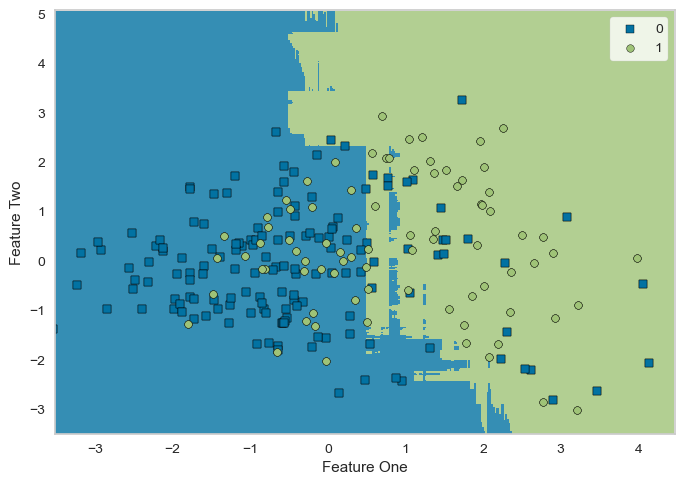

In [30]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')

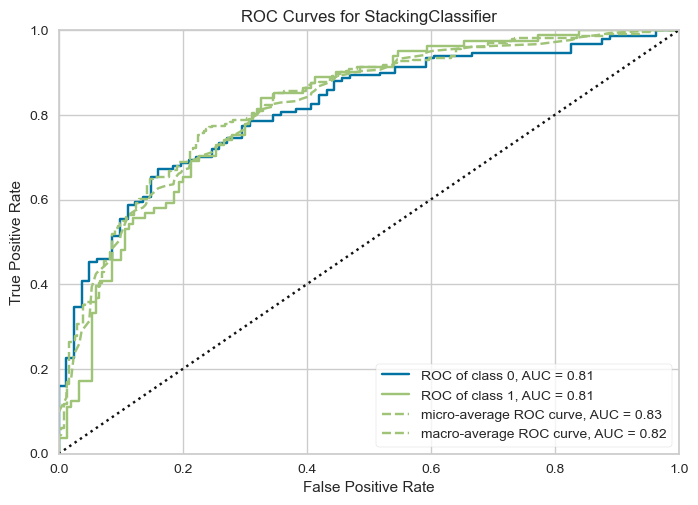

In [31]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot = 'auc')

In [32]:
#prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.8333, precision: 0.8136, recall: 0.6957,    F1: 0.7500, AUC:0.9268


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

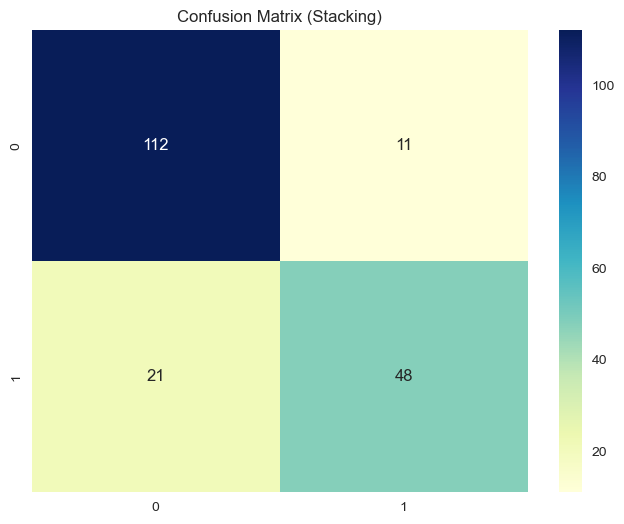

In [33]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

In [34]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7963,0.8406,0.6842,0.7222,0.7027,0.5479,0.5484
1,0.7407,0.8752,0.5789,0.6471,0.6111,0.4176,0.4190
2,0.7963,0.8466,0.5789,0.7857,0.6667,0.5248,0.5375
3,0.7222,0.8075,0.6842,0.5909,0.6341,0.4122,0.4151
4,0.7963,0.8887,0.5789,0.7857,0.6667,0.5248,0.5375
5,0.7593,0.8752,0.5263,0.7143,0.6061,0.4384,0.4490
6,0.8333,0.8812,0.5789,0.9167,0.7097,0.6010,0.6322
7,0.8491,0.8794,0.7778,0.7778,0.7778,0.6635,0.6635
8,0.6792,0.8127,0.5000,0.5294,0.5143,0.2751,0.2754


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

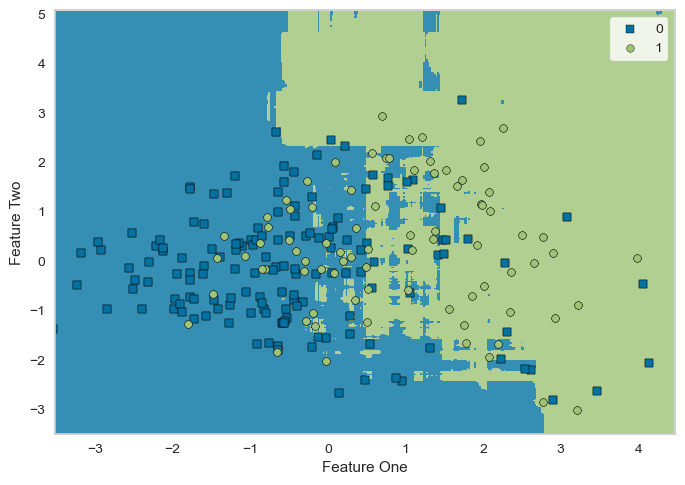

In [35]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='boundary')

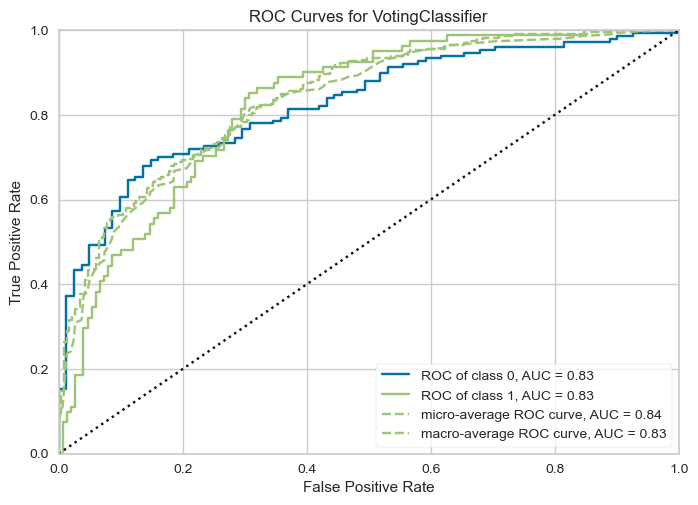

In [36]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot = 'auc')

In [37]:
#prediction
pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.9219, precision: 0.9091, recall: 0.8696,    F1: 0.8889, AUC:0.9615


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

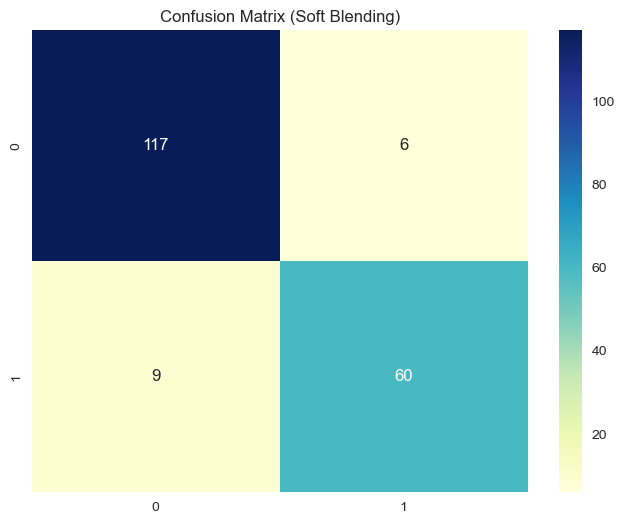

In [38]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

The confusion matrix is ​​also well balanced and the results are good.

---------------------------------------------------------------------------------------------------------------------------------------
# Hard Voting

![](https://miro.medium.com/max/428/1*XnZwlg7Th3nga25sSlanJQ.jpeg)

Picture Credit: https://vitalflux.com


> This function trains a **Majority Rule classifier** for select models passed in the estimator_list param. The output of this function is a score grid with CV scores by fold.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [39]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7963,0.0000,0.6842,0.7222,0.7027,0.5479,0.5484
1,0.7593,0.0000,0.5789,0.6875,0.6286,0.4524,0.4561
2,0.8333,0.0000,0.5789,0.9167,0.7097,0.6010,0.6322
3,0.7593,0.0000,0.7368,0.6364,0.6829,0.4906,0.4940
4,0.8148,0.0000,0.6316,0.8000,0.7059,0.5735,0.5820
5,0.7593,0.0000,0.5263,0.7143,0.6061,0.4384,0.4490
6,0.8519,0.0000,0.6316,0.9231,0.7500,0.6499,0.6736
7,0.8679,0.0000,0.7778,0.8235,0.8000,0.7015,0.7022
8,0.6981,0.0000,0.5000,0.5625,0.5294,0.3083,0.3095


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

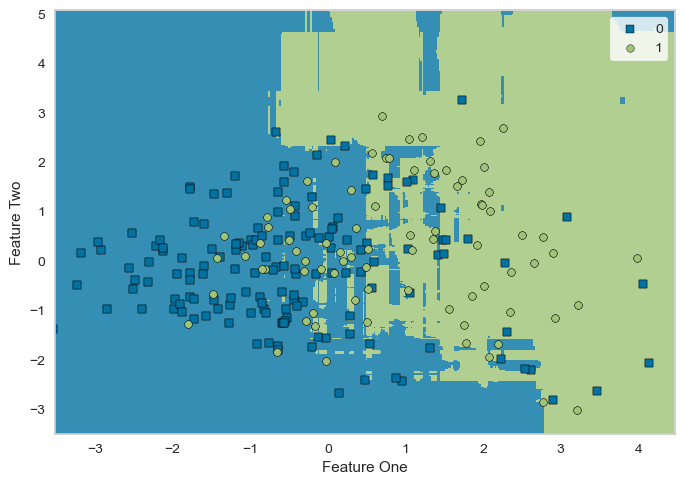

In [40]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

It seems to have been well learned.

# Predicting with the test dateset

In [41]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8906, precision: 0.9000, recall: 0.7826,F1: 0.8372


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

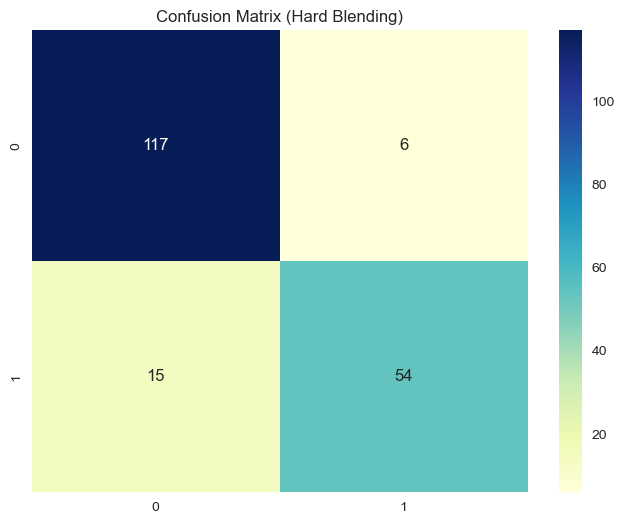

In [42]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

The result is not bad. However, it is worse than the soft blending result.

-----------------------------------------------
# Calibrating the final model

> This function calibrates the probability of a given estimator using isotonic or logistic regression.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [43]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7963,0.8451,0.6842,0.7222,0.7027,0.5479,0.5484
1,0.7778,0.8797,0.5789,0.7333,0.6471,0.4882,0.4954
2,0.8333,0.8511,0.5263,1.0000,0.6897,0.5902,0.6470
3,0.7407,0.8135,0.6842,0.6190,0.6500,0.4449,0.4463
4,0.7778,0.8902,0.5263,0.7692,0.6250,0.4749,0.4921
5,0.7593,0.8737,0.5263,0.7143,0.6061,0.4384,0.4490
6,0.8333,0.8722,0.5789,0.9167,0.7097,0.6010,0.6322
7,0.8679,0.8873,0.7778,0.8235,0.8000,0.7015,0.7022
8,0.6792,0.8079,0.5000,0.5294,0.5143,0.2751,0.2754


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

----------------------------------------------
# Finalizing the last model

> This function trains a given estimator on the entire dataset including the holdout set.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [44]:
final_model = finalize_model(cali_model)

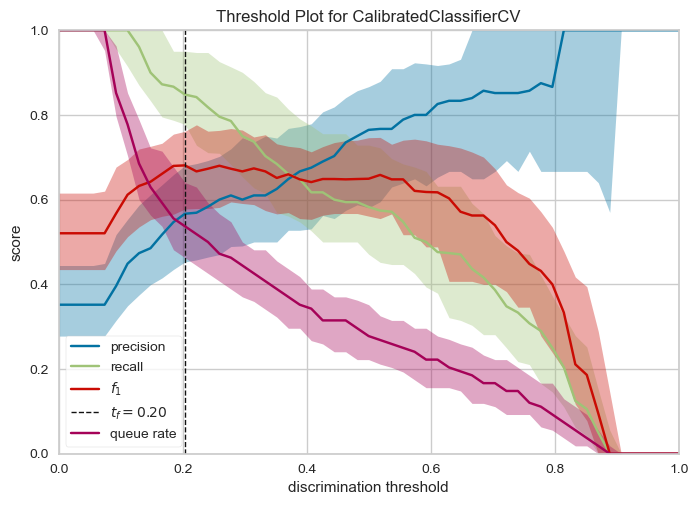

In [45]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='threshold')

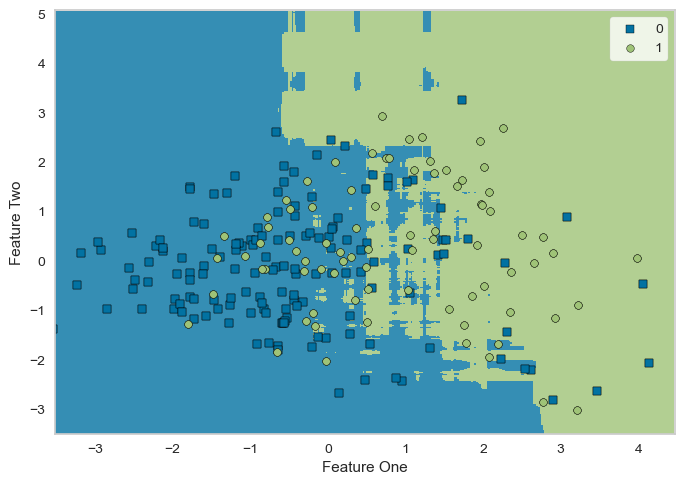

In [46]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

In [47]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9219, precision: 0.9355, recall: 0.8406,F1: 0.8855


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

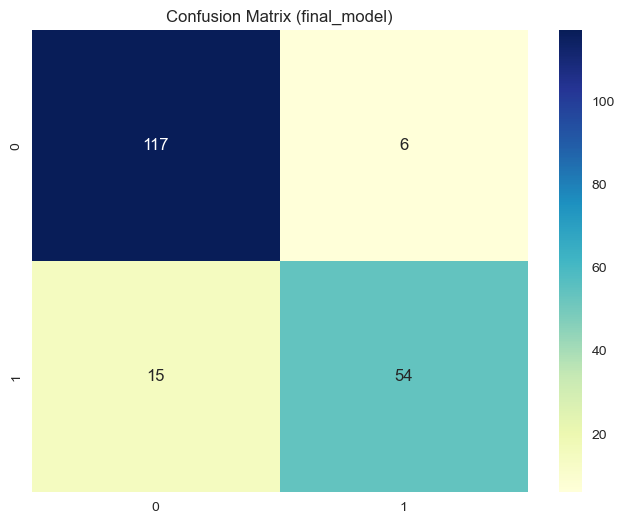

In [48]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')

<hr style="border: solid 3px blue;">

# Implementation

In [49]:
X_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
668,6.0,98.0,58.0,33.000000,190.000000,34.0,0.430,43
324,2.0,112.0,75.0,32.000000,79.799479,35.7,0.148,21
624,2.0,108.0,64.0,20.536458,79.799479,30.8,0.158,21
690,8.0,107.0,80.0,20.536458,79.799479,24.6,0.856,34
473,7.0,136.0,90.0,20.536458,79.799479,29.9,0.210,50
...,...,...,...,...,...,...,...,...
554,1.0,84.0,64.0,23.000000,115.000000,36.9,0.471,28
319,6.0,194.0,78.0,20.536458,79.799479,23.5,0.129,59
594,6.0,123.0,72.0,45.000000,230.000000,33.6,0.733,34
6,3.0,78.0,50.0,32.000000,88.000000,31.0,0.248,26


In [50]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int8)

In [56]:
actual_data=pd.read_excel("actual.xlsx")
actual_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
0,11,100,78,32,190,34,1.5,54
1,0,30,120,30,100,22,0.4,18


In [54]:
final_model = finalize_model(cali_model)

In [69]:
temp=final_model.predict(actual_data)
for a,b in enumerate(temp):
    if(b==0):
        print(str(a+1)+"."+"Healthy")
    else:
        print(str(a+1)+"."+"Dia")

1.Dia
2.Healthy
